In [2]:
import pandas as pd
import os,re,sys
import cv2
import tensorflow as tf
import argparse
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import os,cv2,sys

from matplotlib import pyplot as plt
import numpy as np

Using TensorFlow backend.


In [4]:
# make root directory
os.chdir('C:\\Users\\Adhvaidh\\Desktop\\Imarticus ML\\data')
sys.path.insert(0, './train/')
sys.path.insert(0, './test/')


In [6]:

trainf=pd.read_csv('train.csv')
testf=pd.read_csv('test.csv')

labels=len(trainf.category.unique())

In [7]:
labels

102

In [8]:
trainf.head()

,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58


In [6]:
# i=0
# img=cv2.imread('./train/'+str(trainf.image_id[i])+'.jpg')
# img=cv2.resize(img,(224,224))


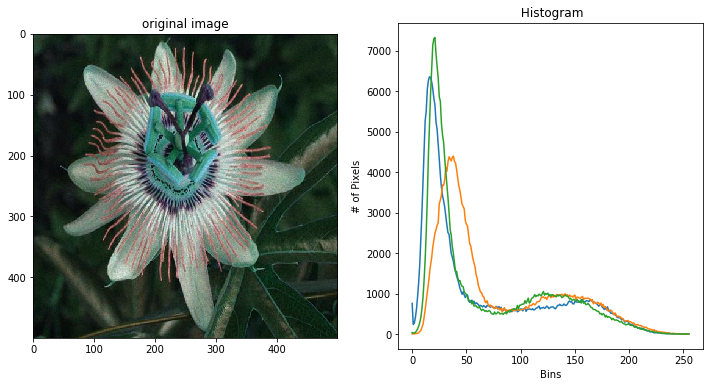

In [9]:
i=0
imag=cv2.imread('./train/'+str(trainf.image_id[i])+'.jpg')
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
#hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

histr = cv2.calcHist([imag],[0],None,[256],[0,256]) 
histg = cv2.calcHist([imag],[1],None,[256],[0,256]) 
histb = cv2.calcHist([imag],[2],None,[256],[0,256]) 
    
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(6*2, 3*2)

ax1.set_title('original image')
ax1.imshow(imag)
ax2.set_title(" Histogram")
ax2.set_xlabel("Bins")
ax2.set_ylabel("# of Pixels")
ax2.plot(histr)
ax2.plot(histg)
ax2.plot(histb)


#plt.xlim([0, 256])
plt.show()

In [10]:
trainf['image'] = trainf['image_id'].apply(lambda x : str(x) +'.jpg')

In [11]:
trainf.head()

,image_id,category,image
0,0,77,0.jpg
1,1,81,1.jpg
2,2,52,2.jpg
3,3,72,3.jpg
4,4,58,4.jpg


In [12]:
## creating labels 
labels=pd.get_dummies(trainf['category'])

In [13]:
len(trainf['category'].unique())

102

In [14]:
labels.index = trainf['image']

In [15]:
labels.head()

,1,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,101,102
image,,,,,,,,,,,,,,,,,,,,,
0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
np.argmax(labels.loc['0.jpg'].values)+1

77

In [17]:
## creating partition dictionary for train and validation
train_data_dir = './train/'
traindataids=os.listdir(train_data_dir)
traindataids=[g for g in traindataids if '.jpg' in g ]
import random 
random.shuffle(traindataids)
partition={}
train_ids=random.sample(traindataids,int(.9*len(traindataids)))
val_ids= [id for id in traindataids if id not in train_ids ]



In [18]:
len(val_ids),len(train_ids)

(1854, 16686)

In [19]:
partition['train'] =train_ids
partition['validation'] =val_ids

In [20]:
list_IDs=traindataids

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

def cnnmodel(nclass):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224,224,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nclass))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model



In [22]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,train_data_dir, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=39, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.train_data_dir=train_data_dir
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size,self.n_classes), dtype=int)
        
        


        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #img=cv2.imread(train_data_dir + ID)
            img_initial = image.load_img(self.train_data_dir + ID)
            img = img_initial.resize((224,224))

            img_array = image.img_to_array(img)
            
            
            X[i,] = img_array

            # Store class
            y[i] = self.labels.loc[ID].values #self.labels[ID]  #y[i]

        return X, y
    #return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [23]:
import numpy as np
from keras.preprocessing import image

train_data_dir = './train/'
from keras.models import Sequential
# from my_classes import DataGenerator

# Parameters
params = {'dim': (224,224),
          'batch_size': 32,
          'n_classes': 102,
          'n_channels': 3,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
training_generator = DataGenerator(partition['train'], labels,train_data_dir, **params)
validation_generator = DataGenerator(partition['validation'], labels,train_data_dir, **params)



In [24]:
cnnm=cnnmodel(102)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [25]:
cnnm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)       

In [26]:
# Train model on dataset
cnnm.fit_generator(generator=training_generator,
                    validation_data=validation_generator,epochs = 200)


Epoch 1/200
521/521 [==============================] - 578s 1s/step - loss: 5.4482 - accuracy: 0.0290 - val_loss: 4.5791 - val_accuracy: 0.0285
Epoch 2/200
 24/521 [>.............................] - ETA: 9:20 - loss: 4.5651 - accuracy: 0.0482

KeyboardInterrupt: 

### trying image augmentation 


In [27]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



In [31]:
### train and valid
partition.keys()
trainf['labelstr'] = trainf['category'].apply(lambda x : str(x))

train_df=trainf[trainf['image'].isin(partition['train'])]
valid_df=trainf[trainf['image'].isin(partition['validation'])]

print(train_df.shape,valid_df.shape)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainf,
        directory=train_data_dir,
        x_col="image",
        y_col='labelstr',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_data_dir,
        x_col="image",
        y_col='labelstr',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


(16686, 4) (1854, 4)
Found 18540 validated image filenames belonging to 102 classes.
Found 1854 validated image filenames belonging to 102 classes.


In [32]:
cnnm2=cnnmodel(102)


In [34]:
cnnm2.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

Epoch 1/50
  47/2000 [..............................] - ETA: 36:44 - loss: 4.5713 - accuracy: 0.0239

KeyboardInterrupt: 

### transfer learning 


In [35]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import img_to_array


#vgg=vgg16.VGG16(weights='imagenet',include_top=True)
#vgg.summary()


In [25]:
#import pydot

In [37]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
# model = VGG16()
# plot_model(model, to_file='vgg.png')

In [38]:
### transfer learning 
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import img_to_array
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Flatten
from keras import optimizers
from keras.models import Model


def transferlearn_model(nclass):
## model architecture
    
    imgsize=224  
    ## customizing the model using vgg architecture
    vgg_model_wtl = vgg16.VGG16(weights='imagenet',input_shape=(imgsize,imgsize,3),
                        include_top=False)
    #vgg_model_wtl.summary()


    ## stacking vgg with custom layers

    layername='block3_conv3'

    mymodel=Model(inputs=vgg_model_wtl.input,outputs=vgg_model_wtl.get_layer(layername).output)
    #mymodel.summary()


    newmodel1=Sequential()
    newmodel1.add(mymodel)

    newmodel1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))

    newmodel1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))


    newmodel1.add(Conv2D(256,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))

    newmodel1.add(GlobalAveragePooling2D())
    newmodel1.add(Dense(64,activation='relu'))
    newmodel1.add(BatchNormalization())

    newmodel1.add(Dense(nclass,activation='softmax'))

    newmodel1.layers[0].trainable=False
    #newmodel1.summary()

    newmodel1.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return newmodel1



In [39]:
model_transferlearn=transferlearn_model(102)

58892288/58889256 [==============================] - 11s 0us/step


In [40]:
model_transferlearn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 56, 56, 256)       1735488   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 128)       295040    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 256)        

In [41]:
# Train model on dataset
model_transferlearn.fit_generator(generator=training_generator,
                    validation_data=validation_generator,epochs = 5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
  5/521 [..............................] - ETA: 35:57 - loss: 0.0566 - accuracy: 0.9902

KeyboardInterrupt: 

In [ ]:
img_initial = image.load_img(self.train_data_dir + ID)
img = img_initial.resize((224,224))

img_array = image.img_to_array(img)

In [ ]:
model_transferlearn.predict()

In [ ]:
### saving model
#model.save('modelsaved.h5')
### loading mode

###model=keras.models.load_model('modelsaved.h5')
